In [1]:
import numpy as np
%pylab inline 
import matplotlib.pyplot as plt

# You don't have to necessarily mess with that code
# only if you want to increase the noise 
class DataProvider:
    
    def __init__(self, N, D, K):
        np.random.seed(1337)
        X = np.zeros((N*K, D)) # this will be 300 lines at 2D
        y = np.zeros(N*K, dtype='uint8') # for the target s
        for j in range(K):
            ix = range(N*j, N*(j+1))
            r = np.linspace(0.0,1,N) # radius
            t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
            X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
            y[ix] = j
        self.X = X
        self.y = y
        
    def get_data(self):
        return self.X, self.y
    
    def plot_data(self):
        plt.scatter(self.X[:,0], self.X[:,1], c=self.y, s = 40, cmap = plt.cm.Spectral)

    def plot_classifier(self, classifier):
        # plot the resulting classifier
        h = 0.02
        x_min, x_max = self.X[:, 0].min() - 1, self.X[:, 0].max() + 1
        y_min, y_max = self.X[:, 1].min() - 1, self.X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        
        X_test = np.c_[xx.ravel(), yy.ravel()]
        Z = classifier.test(X_test)
        Z = Z.reshape(xx.shape)
        fig = plt.figure()
        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
        plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.show()
        

Populating the interactive namespace from numpy and matplotlib


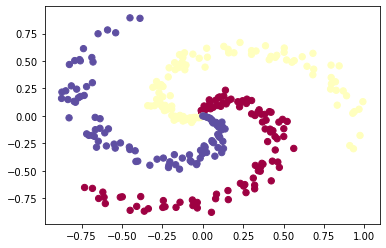

In [2]:

N = 100 # number of training points per class
D = 2 # dimensions
K = 3 # classes 

dp = DataProvider(N,D,K)
X, y = dp.get_data()
dp.plot_data()

In [3]:
# so we got ourselves a training set with targets
# we know how to forward propagate and how to 
# backpropagate with cross-entropy loss over a softmax
# layer

# let's put these things to good use and train our first
# neural network!

class NeuralNetwork:
    
    # D input dimension, H hidden width, K output classes
    def __init__(self, D, H, K):
        # let's have some weights for the first layer 
        # it'll get num_examples * D as design matrix
        # it has to transform this into H hidden 
        # activations
        self.W1 = 0.01*np.random.randn(D,H)
        self.W2 = 0.01*np.random.randn(H,K)
        
        # some biases are nice as well
        self.b1 = np.zeros((1,H)) # H biases for every hidden
        self.b2 = np.zeros((1,K))
        
        # now for some hyperparameters
        self.reg = 0.1
        self.step_size = 0.01
        
        # store some of the values for later
        self.K = K
        
    def forward(self, X):
        # we process a whole batch of data at once
        # produce outputs that can then be used
        # to feed targets (loss functions) backwards
        self.X = X # store batch for later
        self.num_examples = X.shape[0]
        self.H = np.maximum(np.dot(X, self.W1) + self.b1,0)
        self.scores = np.dot(self.H, self.W2) + self.b2
        
        # now that we have scores, let's convert them to probs
        exp_scores = np.exp(self.scores)
        self.probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return self.probs
    
    def backward(self, target):
        # now first we want some loss         
        # index into the probs array by means of target \in {0,1,2}
        correct_probs = self.probs[range(self.num_examples), target]
        correct_logprobs = -np.log(correct_probs)
        # we now have a vector of correct log probs for our batch
        # let's sum it
        self.data_loss = np.sum(correct_logprobs)/self.num_examples
        # multiply by 0.5 to make the gradient easier (we'll 
        # get 2 down from w^t w )

        self.reg_loss = 0.5*self.reg*  \
          (np.sum(self.W1*self.W1)+ \
           np.sum(self.W2*self.W2))

        self.loss = self.data_loss + self.reg_loss
        
        # now for some backprop ...
        # -------------------------------
        # through softmax: Loss = prob - target 
        self.dscores = self.probs.copy()
        # subtract 1 from all true class prop entries
        self.dscores[range(self.num_examples), target] -= 1
        # normalize by the number of examples 
        self.dscores /= self.num_examples
        # -------------------------------
        # from before softmax towards hidden activation
        self.dW2 = np.dot(self.H.T, self.dscores)
        # we have to sum for the biases since we have the whole batch
        # in axis 0
        self.db2 = np.sum(self.dscores, axis=0, keepdims=True)
        self.dW2 += self.reg*self.W2 # for the regularization part
        self.dH_out = np.dot(self.dscores, self.W2.T)
        self.dH_in = self.dH_out.copy()
        # for every negative value of H, set gradient to zero 
        self.dH_in[self.H <= 0] = 0
        
        # -------------------------------
        # from hidden activation towards input
        # same backprop steps as before
        self.dW1 = np.dot(self.X.T, self.dH_in)
        self.db1 = np.sum(self.dH_in, axis=0, keepdims=True)
        # reg again 
        self.dW1 += self.reg*self.W1
        return self.loss, self.dW1, self.db1, self.dW2, self.db2
    
    def train(self, X, target, iterations=10):
        for i in range(iterations):
            probs = self.forward(X)
            # here we could visualize the decision boundaries with probs
            loss, dW1, db1, dW2, db2 = self.backward(target)
            
            if i % 1000 == 0:
                print("Iteration ", i, ": ", loss)
                predicted_class = np.argmax(self.probs, axis=1)
                print("training accuracy: %.2f" % (np.mean(predicted_class == target)))   
                dp.plot_classifier(self)
            # perform parameter update
            self.W1 += - self.step_size * dW1
            self.W2 += - self.step_size * dW2
            self.b1 += - self.step_size * db1
            self.b2 += - self.step_size * db2
            
    # just return the most probable class per test point
    def test(self, X):
        probs = self.forward(X)
        predicted_class = np.argmax(probs, axis=1)
        return predicted_class


Iteration  0 :  1.0987040301801452
training accuracy: 0.33


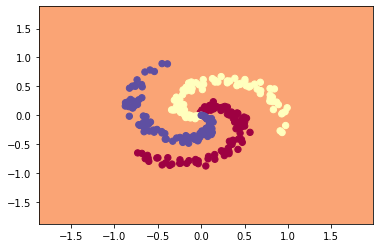

Iteration  1000 :  0.6751802032799468
training accuracy: 0.59


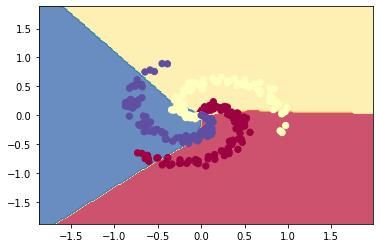

Iteration  2000 :  0.6264020865935557
training accuracy: 0.65


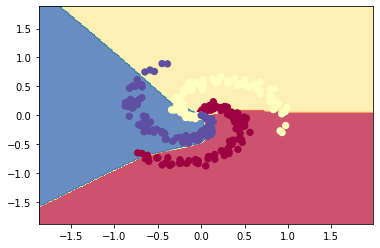

Iteration  3000 :  0.4972012022527255
training accuracy: 0.75


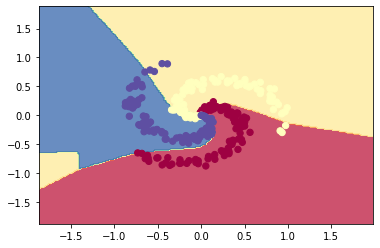

Iteration  4000 :  0.37914908948151227
training accuracy: 0.84


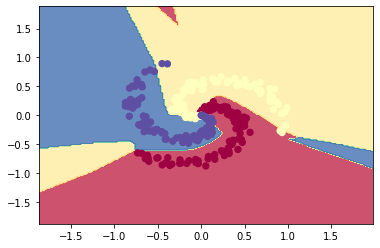

Iteration  5000 :  0.3322820798535695
training accuracy: 0.87


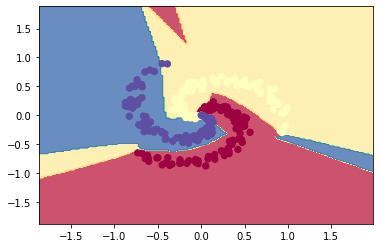

Iteration  6000 :  0.31193622161396684
training accuracy: 0.91


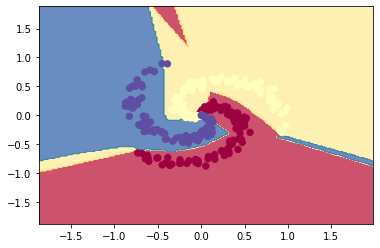

Iteration  7000 :  0.3012577199228281
training accuracy: 0.94


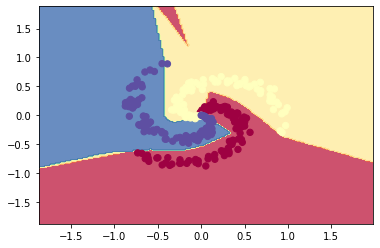

Iteration  8000 :  0.29485957755674447
training accuracy: 0.95


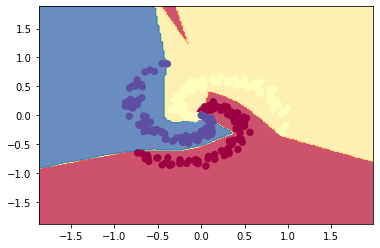

Iteration  9000 :  0.28989419591892157
training accuracy: 0.95


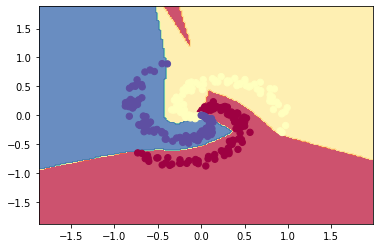

In [4]:
X, t = dp.get_data()
H = 100
network = NeuralNetwork(D,H,K)
network.step_size = 0.1
network.reg = 0.001
network.train(X,t,iterations=10000)

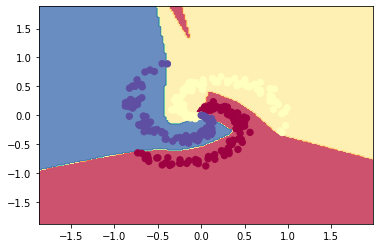

In [5]:
dp.plot_classifier(network)
#network.test(X)